In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import os
import seaborn as sns

In [2]:
# Read CSVs
PatientConsumption = pd.read_csv('PatientConsumption 2018-2019.csv').drop_duplicates()
PurchasedOrders    = pd.read_csv('PurchasedOrders 2018-2019.csv').drop_duplicates()
IncompleteOrders   = pd.read_csv('IncompleteOrders 2018-2019.csv').drop_duplicates()
PatentDrugs        = pd.read_csv('Diccionario_v3.csv').drop_duplicates()

# Retrieve date columns and apply to_datetime, set amount columns as numeric
date_columns   = [column for column in PatientConsumption.columns if 'Date' in column]
amount_columns = [column for column in PatientConsumption.keys() if 'Amount' in column]
PatientConsumption[date_columns]   = PatientConsumption[date_columns].apply(pd.to_datetime)
PatientConsumption[amount_columns] = PatientConsumption[amount_columns].astype(int)

date_columns   = [column for column in PurchasedOrders.columns if 'Date' in column]
amount_columns = [column for column in PurchasedOrders.keys() if 'Amount' in column]
PurchasedOrders[date_columns]   = PurchasedOrders[date_columns].apply(pd.to_datetime)
PurchasedOrders[amount_columns] = PurchasedOrders[amount_columns].astype(int)

date_columns   = [column for column in IncompleteOrders.columns if 'Date' in column]
amount_columns = [column for column in IncompleteOrders.keys() if 'Amount' in column]
IncompleteOrders[date_columns]   = IncompleteOrders[date_columns].apply(pd.to_datetime)
IncompleteOrders[amount_columns] = IncompleteOrders[amount_columns].astype(int)

_______________

In [3]:
PatientConsumption.dtypes

ConsumptionDate      datetime64[ns]
Department                   object
ConsumptionNumber           float64
MedCode                     float64
MedDescription               object
AmountConsumed                int64
UnitaryCost                 float64
TotalCost                   float64
dtype: object

In [4]:
PurchasedOrders.dtypes

RequestNumber                    int64
RequestDate             datetime64[ns]
PurchaseNumber                 float64
OrderDate               datetime64[ns]
RequiredDeliveryDate    datetime64[ns]
SupplierName                    object
MedCode                          int64
MedDescription                  object
Outflow                        float64
AmountRequested                  int64
AmountPurchased                  int64
dtype: object

In [5]:
IncompleteOrders.dtypes

SupplierName                          object
OrderNumber                          float64
OrderDate                     datetime64[ns]
RequiredDeliveryDate          datetime64[ns]
RequestNumber                        float64
RequestDate                   datetime64[ns]
CostCenter                            object
MedCode                                int64
MedDescription                        object
InvoiceNumber                         object
ReceivedDate                  datetime64[ns]
AmountRequested                        int64
AmountPurchased                        int64
AmountReceived                         int64
OrderPercentageFulfillment           float64
dtype: object

In [6]:
PatentDrugs.dtypes

MedCode             int64
MedDescription     object
Compound           object
MedFamily          object
MedPriceMXN       float64
MinStock            int64
MaxStock            int64
dtype: object

___
## Time series

Define top compounds to analyze

In [7]:
TopCompounds = ['IPRATROPIO/ SALBUTAMOL',
                'KETOPROFENO',
                'VANCOMICINA',
                'BROMURO DE IPRATROPIO',
                'NORFLEX',
                'ALBUMINA',
                'DIOVAN',
                'FLUCONAZOL',
                'CIPROFLOXACINO',
                'EMEND',
                'CLARITROMICINA']

Merge drugs datasets with dictionary. Set `YearMonth` to first day of each month for monthly analysis.

In [8]:
# Consumed
MedConsumption = pd.merge(PatientConsumption, PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
# Requested, Purchased
MedOrders = pd.merge(PurchasedOrders, PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
MedOrders['YearMonth'] = pd.to_datetime(MedOrders['RequestDate'].dt.year*100+MedOrders['RequestDate'].dt.month, format='%Y%m')
# Incomplete
MedIncompleteOrders = pd.merge(IncompleteOrders[IncompleteOrders['RequestNumber']!=0], PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
MedIncompleteOrders['YearMonth'] = pd.to_datetime(MedIncompleteOrders['RequestDate'].dt.year*100+MedIncompleteOrders['RequestDate'].dt.month, format='%Y%m')

`AmountRequested` is repeated in several rows for teh same Request. `AmountPurchased` appears once per Suplier (row).

In [9]:
MedOrders[(MedOrders['RequestNumber']==56308) & (MedOrders['MedCode']==3300913)][['YearMonth','RequestNumber','MedCode','SupplierName','AmountRequested','AmountPurchased']]

,YearMonth,RequestNumber,MedCode,SupplierName,AmountRequested,AmountPurchased
6429,2018-07-01,56308,3300913,"CENTRO MEDICO FARMACIA, S.A. DE C.V.",20,2
6430,2018-07-01,56308,3300913,"PHARMAPLUS, SA DE CV (FARMACIA SAN PABLO)",20,2
6432,2018-07-01,56308,3300913,"NUEVA FARMACIA SAN BORJA, S.A. DE C.V.",20,2
6433,2018-07-01,56308,3300913,FARMACIA FRANCO ARGENTINA S.A. DE C. V.,20,1


Compute `AmountRequested`, `AmountPurchased`, `AmountReceived` and `AmountMissing` per `[Month,RequestNumber,MedCode]`.

In [10]:
# 26763 requests
AmountRequested = MedOrders[['YearMonth','RequestNumber','MedCode','AmountRequested']].drop_duplicates()
# 26763 purchases
AmountPurchased = MedOrders.groupby(['YearMonth','RequestNumber','MedCode']).sum()['AmountPurchased'].reset_index()
# 1013 incomplete
AmountReceived = MedIncompleteOrders.groupby(['YearMonth','RequestNumber','MedCode']).sum()['AmountReceived'].reset_index()

# Merge columns to a total of 26763 rows
df = pd.merge(AmountRequested, AmountPurchased, on=['YearMonth','RequestNumber','MedCode'], how='left')
df = pd.merge(df, AmountReceived, on=['YearMonth','RequestNumber','MedCode'], how='left')
# if AmountReceived.isna() : order is complete
df['AmountReceived'] = df.apply(lambda x: x['AmountPurchased'] if pd.isna(x['AmountReceived']) else x['AmountReceived'], axis=1)
# compute shortage amount
df['AmountMissing'] = df['AmountRequested'] - df['AmountReceived']

df[(df['AmountPurchased']!=df['AmountReceived']) & (df['AmountRequested']!=df['AmountPurchased'])].head()

,YearMonth,RequestNumber,MedCode,AmountRequested,AmountPurchased,AmountReceived,AmountMissing
438,2018-01-01,52936,3300586,1,2,0.0,1.0
677,2018-01-01,53062,3300627,10,19,1.0,9.0
717,2018-01-01,53076,3300952,15,30,0.0,15.0
1975,2018-03-01,53801,3305045,20,270,0.0,20.0
2069,2018-03-01,53877,3300072,18,20,0.0,18.0


Compute `AmountConsumed` per `[Month,Compound]`.

In [11]:
# Consumed
AmountConsumed = MedConsumption.groupby(['ConsumptionDate','Compound']).sum()['AmountConsumed'].reset_index()
AmountConsumed['YearMonth'] = pd.to_datetime(AmountConsumed['ConsumptionDate'].dt.year*100+AmountConsumed['ConsumptionDate'].dt.month, format='%Y%m')
AmountConsumed = AmountConsumed.loc[:, ['YearMonth','Compound','AmountConsumed']]
AmountConsumed.head()

,YearMonth,Compound,AmountConsumed
0,2018-01-01,PARACETAMOL,4
1,2018-01-01,ACETATO DE TERLIPRESINA,13
2,2018-01-01,ACETAZOLAMIDA,2
3,2018-01-01,ACETILCISTEINA,21
4,2018-01-01,ACICLOVIR,3


Compute `AmountRequested`, `AmountPurchased`, `AmountReceived` and `AmountMissing` per `[Month,Compound]`.

In [12]:
AmountOrdered = pd.merge(df, PatentDrugs[['MedCode','Compound']], on='MedCode', how='left').groupby(['YearMonth','Compound']).sum()[['AmountRequested','AmountPurchased','AmountReceived','AmountMissing']].reset_index()
AmountOrdered.head()

,YearMonth,Compound,AmountRequested,AmountPurchased,AmountReceived,AmountMissing
0,2018-01-01,PARACETAMOL,4,2,2.0,2.0
1,2018-01-01,ACETATO DE TERLIPRESINA,9,9,9.0,0.0
2,2018-01-01,ACETAZOLAMIDA,2,2,2.0,0.0
3,2018-01-01,ACETILCISTEINA,21,18,14.0,7.0
4,2018-01-01,ACICLOVIR,2,2,2.0,0.0


Merge all amounts on `[Month,Compound]`.

In [13]:
MonthlyCompounds = pd.merge(AmountOrdered, AmountConsumed, on=['YearMonth','Compound'], how='outer')
# fill AmountConsumed.isna() with zeros
#MonthlyCompounds['AmountConsumed'] = MonthlyCompounds['AmountConsumed'].fillna(0)
MonthlyCompounds = MonthlyCompounds.fillna(0)
MonthlyCompounds.head()

,YearMonth,Compound,AmountRequested,AmountPurchased,AmountReceived,AmountMissing,AmountConsumed
0,2018-01-01,PARACETAMOL,4.0,2.0,2.0,2.0,4.0
1,2018-01-01,ACETATO DE TERLIPRESINA,9.0,9.0,9.0,0.0,13.0
2,2018-01-01,ACETAZOLAMIDA,2.0,2.0,2.0,0.0,2.0
3,2018-01-01,ACETILCISTEINA,21.0,18.0,14.0,7.0,21.0
4,2018-01-01,ACICLOVIR,2.0,2.0,2.0,0.0,3.0


Plot time series

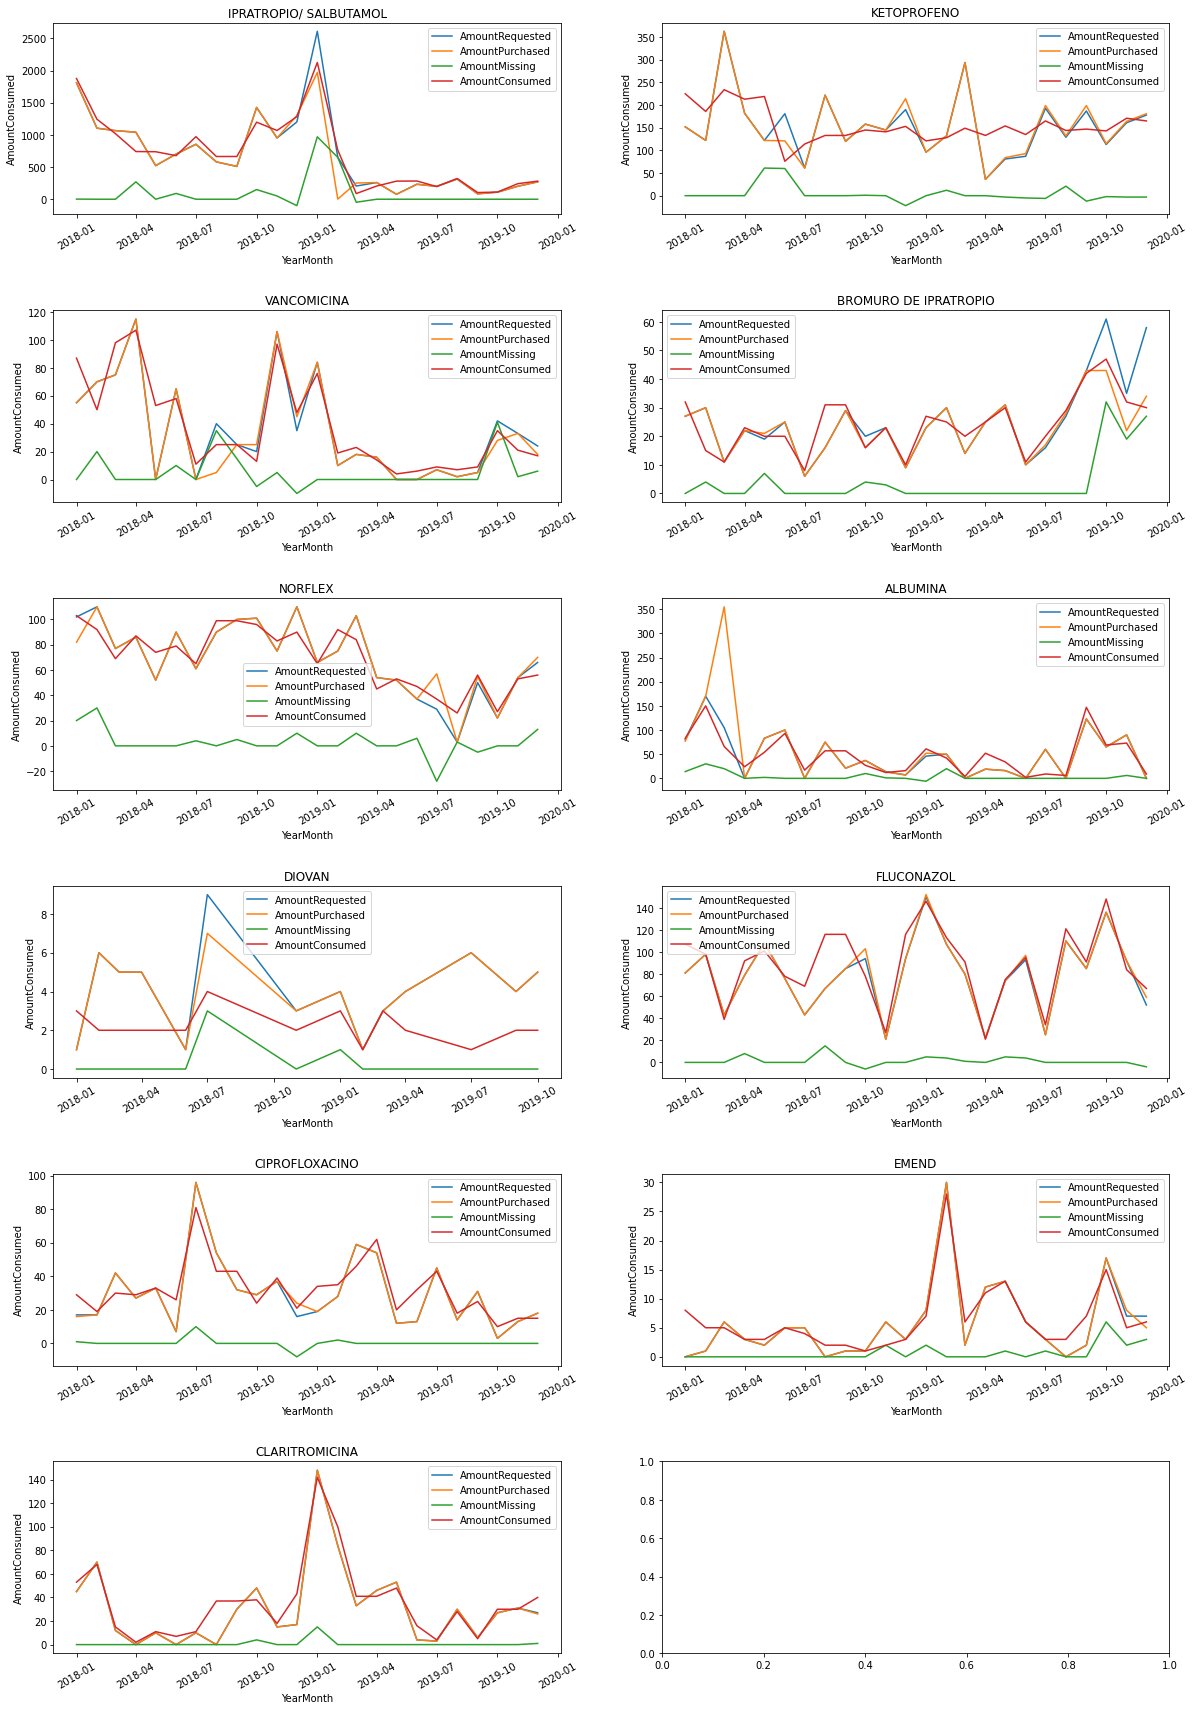

In [14]:
# Plot top compounds
fig, axes = plt.subplots(6, 2, figsize=(20,30))
fig.subplots_adjust(hspace=0.5)
for ax, Compound in zip(axes.flatten(), TopCompounds):
    sns.lineplot(data=MonthlyCompounds[MonthlyCompounds["Compound"]==Compound], x='YearMonth', y='AmountRequested', ax=ax)
    sns.lineplot(data=MonthlyCompounds[MonthlyCompounds["Compound"]==Compound], x='YearMonth', y='AmountPurchased', ax=ax)
    #sns.lineplot(data=MonthlyCompounds[MonthlyCompounds["Compound"]==Compound], x='YearMonth', y='AmountReceived', ax=ax)
    sns.lineplot(data=MonthlyCompounds[MonthlyCompounds["Compound"]==Compound], x='YearMonth', y='AmountMissing', ax=ax)
    sns.lineplot(data=MonthlyCompounds[MonthlyCompounds["Compound"]==Compound], x='YearMonth', y='AmountConsumed', ax=ax)
    #ax.legend(["AmountRequested","AmountPurchased",'AmountReceived','AmountMissing','AmountConsumed'])
    ax.legend(["AmountRequested","AmountPurchased",'AmountMissing','AmountConsumed'])
    ax.tick_params('x', labelrotation=30)
    ax.set(title=Compound)

___
## Some more graphs

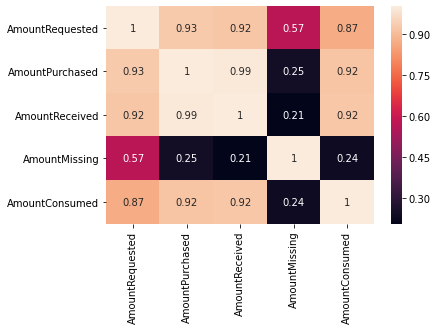

In [15]:
plt.figure(figsize=(6,4))
sns.heatmap(data=MonthlyCompounds.corr(), annot=True);

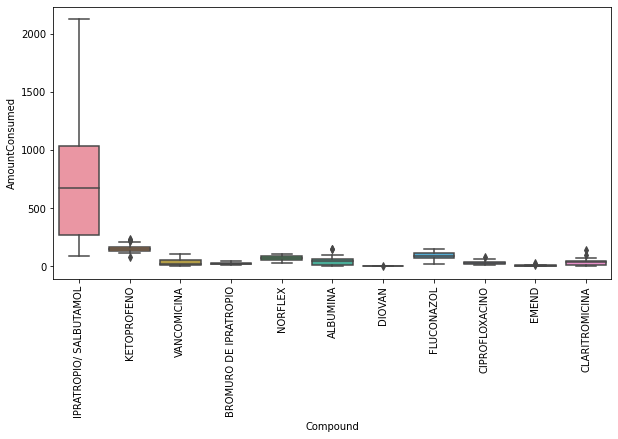

In [16]:
plot_df = MedConsumption[MedConsumption['Compound'].isin(TopCompounds)].groupby(['ConsumptionDate','Compound']).sum()['AmountConsumed'].reset_index()

plt.figure(figsize=(10,5))
sns.boxplot(data=plot_df, x='Compound', y='AmountConsumed', order=TopCompounds)
plt.xticks(rotation=90);

___

# Outflow analysis

In [17]:
TopS = ['COMBIVENT 0.5/2.5MG AMPOLLETA 2.5ML (IPRATROPIO/ SALBUTAMOL)',
        'FIRAC PLUS 100MG AMP (CLONIXINATO LISINA/PARGEVER)',
        'FLIXOTIDE 2MG AMP 2ML (FLUTICASONA)',
        'SOMAZINA 1G AMP 4ML (CITICOLINA)',
        'INDAFLEX 2.5% CREMA 40G TUBO(INDOMETACINA)',
        'MYDOCALM A C/30 CAPS TOLPERISONA /PARACETAMOL',
        'VANCOCIN CP 1G AMP (VANCOMICINA)',
        'COMBIVENT RESPIMAT 1.68/8.77MG C/DOSIF.(IPRATRO./ SALBUTAMOL',
        'LIPITOR 80MG C/30 TAB(ATORVASTATINA)']

In [18]:
AmountConsumed = MedConsumption.groupby(['ConsumptionDate','MedDescription']).sum()['AmountConsumed'].reset_index()
AmountConsumed['YearMonth'] = pd.to_datetime(AmountConsumed['ConsumptionDate'].dt.year*100+AmountConsumed['ConsumptionDate'].dt.month, format='%Y%m')
AmountConsumed = AmountConsumed.loc[:, ['YearMonth','MedDescription','AmountConsumed']]
AmountConsumed.head()

,YearMonth,MedDescription,AmountConsumed
0,2018-01-01,ACC 200MG C/20 TAB EFERV (ACETILCISTEINA),1
1,2018-01-01,ACC 600MG TAB EFERV (ACETILCISTEINA),2
2,2018-01-01,ACELER CO 2% CREMA 15G(ACIDO FUSIDICO/BETAMETA...,2
3,2018-01-01,ACETA DIAZOL 250MG C/30 TAB(ACETAZOLAMIDA),2
4,2018-01-01,ACTRON 200 200MG C/10 CAPS (IBUPROFENO),1


In [19]:
AmountOutflow = MedOrders[['YearMonth','RequestDate','RequestNumber','MedDescription','Outflow']].drop_duplicates()
AmountOutflow = AmountOutflow.groupby(['YearMonth','MedDescription']).sum()['Outflow'].reset_index()
AmountOutflow.head()

,YearMonth,MedDescription,Outflow
0,2018-01-01,A.S. COR (NORFENEFRINA) 1 G/100 ML GOTAS 24 ML,1077.0
1,2018-01-01,ACANOL (LOPERAMIDA) 2MG TAB C/12,571.0
2,2018-01-01,ACC (ACETILCISTEINA) 600MG TAB EFERV C/20,198.0
3,2018-01-01,ACETA DIAZOL (ACETAZOLAMIDA) 250MG TAB C/30,460.0
4,2018-01-01,ACTRON (IBUPROFENO) 400MG CAP C/10,1457.0


In [20]:
plot_df = pd.merge(AmountConsumed, AmountOutflow, on=['YearMonth','MedDescription'], how='outer')
plot_df = plot_df[plot_df['YearMonth']>pd.to_datetime('2019-05-31')].fillna(0)
#plot_df = plot_df.fillna(0)
plot_df.head(5)

,YearMonth,MedDescription,AmountConsumed,Outflow
9274,2019-06-01,A.S. COR (NORFENEFRINA) 1 G/100 ML GOTAS 24 ML,2.0,4.0
9275,2019-06-01,ABRAXUS (ALBUMINA-PACLITAXEL) 100MG/16.7ML FAM,11.0,0.0
9276,2019-06-01,ACC (ACETILCISTEINA) 600MG TAB EFERV C/20,1.0,2.0
9277,2019-06-01,ACTRON (IBUPROFENO) 400MG CAP C/10,1.0,1.0
9278,2019-06-01,ACTRON (IBUPROFENO) 600MG CAP C/10,52.0,30.0


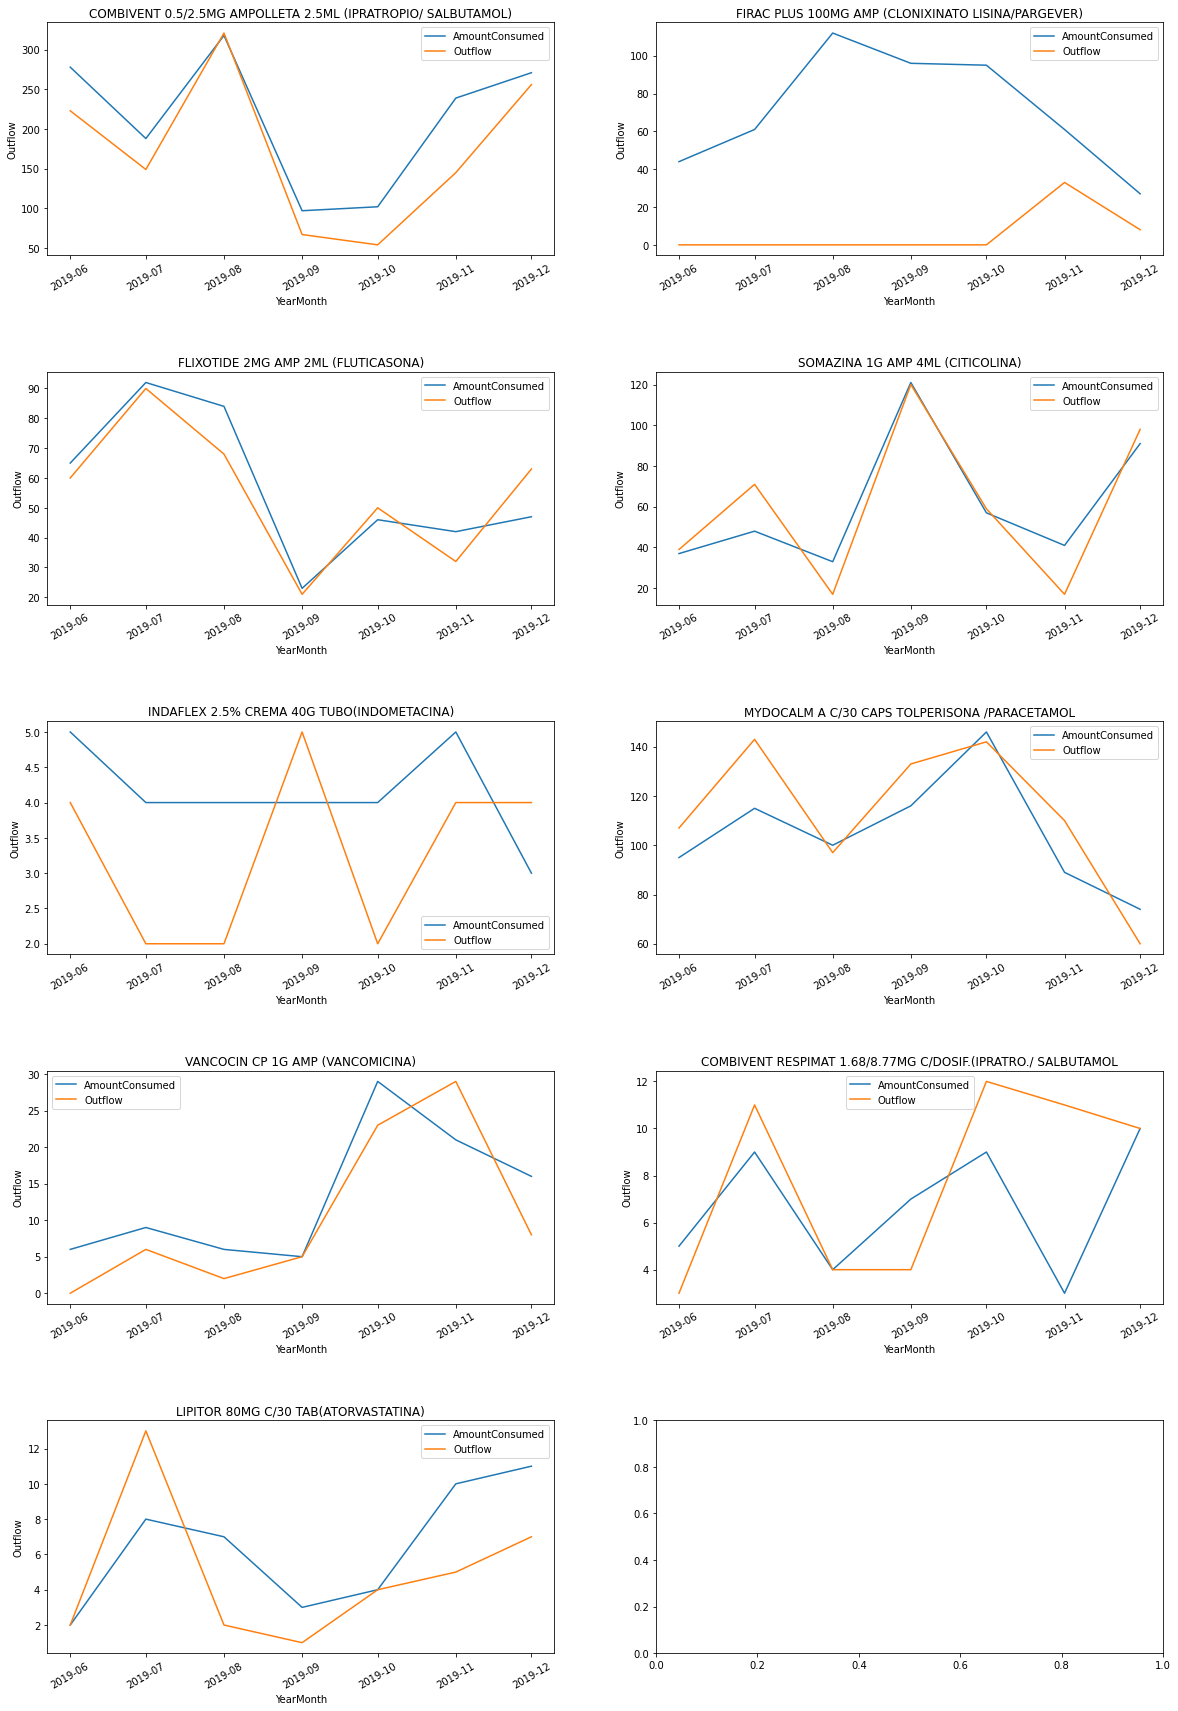

In [21]:
fig, axes = plt.subplots(5, 2, figsize=(20,30))
fig.subplots_adjust(hspace=0.5)
for ax, MedCode in zip(axes.flatten(), TopS):
    sns.lineplot(data=plot_df[plot_df["MedDescription"]==MedCode], x='YearMonth', y='AmountConsumed', ax=ax)
    sns.lineplot(data=plot_df[plot_df["MedDescription"]==MedCode], x='YearMonth', y='Outflow', ax=ax)
    ax.legend(["AmountConsumed","Outflow"])
    ax.tick_params('x', labelrotation=30)
    ax.set(title=MedCode)

___

In [26]:
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow'